In [1]:
import numpy as np
import pandas as pd
import yfinance as yf  # Using yfinance instead of pandas_datareader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

In [2]:
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)
    
ticker = yf.Ticker("GOOGL")
df = ticker.history(start=start_date, end=end_date)

In [4]:
df.to_csv('AAPL.csv')
print(df.shape)
print(f"Date range: {df.index[0]} to {df.index[-1]}")

(1255, 7)
Date range: 2020-10-06 00:00:00-04:00 to 2025-10-03 00:00:00-04:00


In [5]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-10-06 00:00:00-04:00,73.269662,73.717569,71.755606,72.054047,26096000,0.0,0.0
2020-10-07 00:00:00-04:00,72.465701,72.945394,71.170632,72.457260,36108000,0.0,0.0
2020-10-08 00:00:00-04:00,72.770593,73.891857,72.770593,73.663437,26076000,0.0,0.0
2020-10-09 00:00:00-04:00,74.131703,75.074701,73.840711,75.005180,32966000,0.0,0.0
2020-10-12 00:00:00-04:00,76.373250,78.876978,75.941225,77.693642,55344000,0.0,0.0


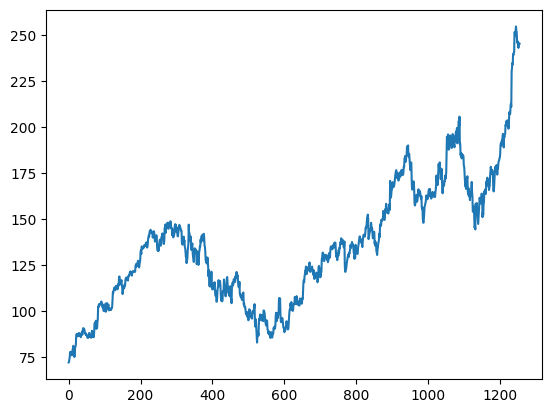

In [ ]:
df_close = df['Close']
plt.plot(df_close)

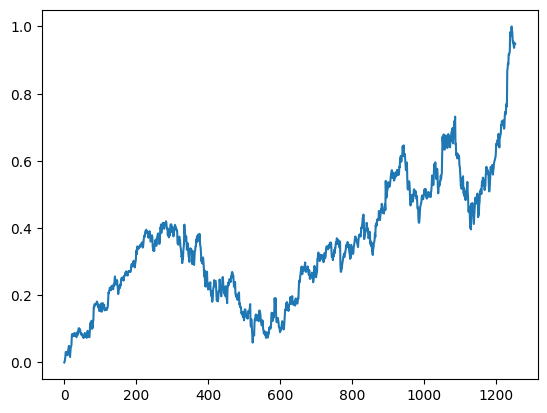

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(np.array(df_close).reshape(-1, 1))
plt.plot(df_scaled)

In [16]:
training_size=int(len(df_scaled)*0.70)
test_size=len(df_scaled)-training_size
train_data,test_data=df_scaled[0:training_size,:],df_scaled[training_size:len(df_scaled),:]
len(train_data),len(test_data)

(878, 377)

In [17]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
(X_train.shape), (y_train.shape)


((777, 100), (777,))

In [21]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [24]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

c:\Users\velgn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=150,  
    batch_size=64, 
    verbose=1
)

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - loss: 0.0383 - val_loss: 0.0709
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 0.0056 - val_loss: 0.0188
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 0.0021 - val_loss: 0.0165
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.0018 - val_loss: 0.0097
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - loss: 0.0012 - val_loss: 0.0071
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 9/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 10/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 11/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 0.0011 - val_loss: 0.0040
Epoch 12/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [27]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

In [28]:
train_rmse = math.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_inv, test_predict))

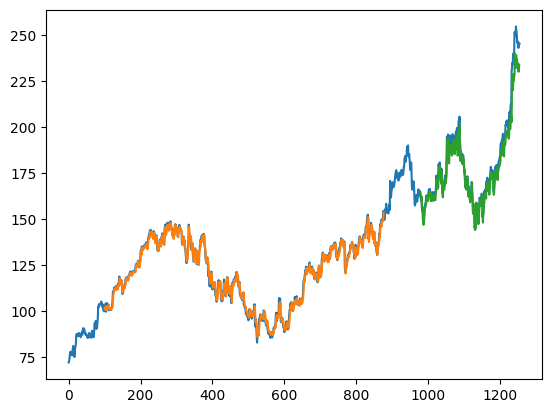

In [32]:
look_back=100
trainPredictPlot = np.empty_like(df_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(df_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_scaled)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [37]:
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input[0])
lst_output = []
n_steps=100
i=0

while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

(lst_output)

[0.8758971]
101
1 day input [0.50895307 0.50125033 0.51343274 0.51534475 0.5013596  0.52637999
 0.53899945 0.52588831 0.55008923 0.54713923 0.54440776 0.54375227
 0.52894757 0.51337811 0.5235938  0.52446798 0.55435029 0.56868069
 0.58240939 0.5755724  0.56654757 0.56091388 0.57240003 0.56791494
 0.55352999 0.51699312 0.50906225 0.51770425 0.53909025 0.55473321
 0.58202647 0.56944644 0.56731324 0.58262808 0.58749602 0.57250938
 0.55921831 0.57157956 0.57704911 0.59110602 0.59859925 0.60100595
 0.60631143 0.60964786 0.61774279 0.64530954 0.65209182 0.64602058
 0.65663155 0.66215581 0.6588741  0.67621264 0.68047896 0.65515476
 0.64000406 0.67232923 0.67030554 0.67807227 0.68042424 0.70722516
 0.70492798 0.71772678 0.71017883 0.71553895 0.72078972 0.71860197
 0.70804571 0.69573909 0.69809098 0.73276814 0.74589515 0.73851117
 0.7403708  0.76312434 0.77007068 0.7615382  0.8671558  0.87612591
 0.89089378 0.88678784 0.91739021 0.91487191 0.92144127 0.92379533
 0.98297438 0.98051089 0.97158747 

[[0.8758971095085144],
 [0.7922466397285461],
 [0.7355688214302063],
 [0.7168892025947571],
 [0.712457537651062],
 [0.7057766318321228],
 [0.6932192444801331],
 [0.6779428124427795],
 [0.6637679934501648],
 [0.6525565981864929],
 [0.6443343758583069],
 [0.6382802128791809],
 [0.6334968209266663],
 [0.6293357610702515],
 [0.6254268288612366],
 [0.6215863823890686],
 [0.6177158355712891],
 [0.6137393116950989],
 [0.60958331823349],
 [0.605181872844696],
 [0.6004877686500549],
 [0.5954816341400146],
 [0.5901733040809631],
 [0.584597110748291],
 [0.5788046717643738],
 [0.5728568434715271],
 [0.5668174028396606],
 [0.5607485175132751],
 [0.5547080636024475],
 [0.5487481951713562]]

In [38]:
len(df_scaled)

1255

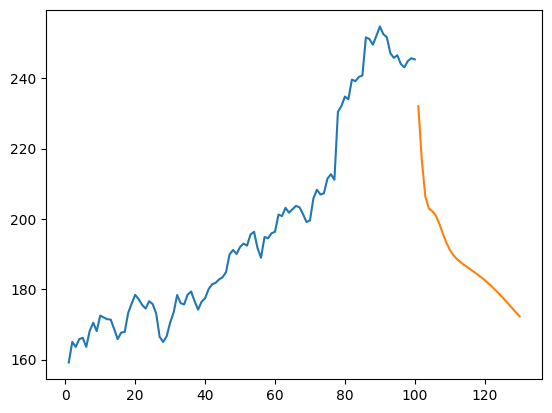

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

plt.plot(day_new,scaler.inverse_transform(df_scaled[1155:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

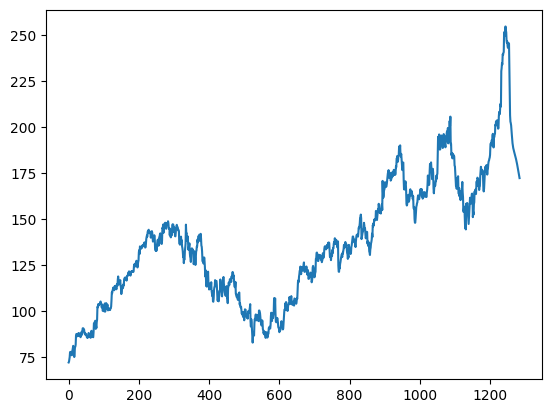

In [61]:
df_out=df_scaled.tolist()
df_out.extend(lst_output)
df_out=scaler.inverse_transform(df_out).tolist()
plt.plot(df_out)